# Random Forest Model Training Notebook

This Jupyter Notebook serves as a documentation and workflow for training the Random Forest model. 

## Data Processing

In the following cells, we import the necessary libraries and load the training and testing datasets. There are 2 variables that can be changed depending on the kind of dataset we want :
* `withOutliers` : True or False
* `data` : 'normal' | 'oversampled' | 'undersampled' 

NOTE : Make sure you already made the datasets with the commands:
- `make data`
- `make features`

We also perform data preprocessing steps such as encoding labels. Other preprocessing steps such as removing correlations with pca, and scaling the data are done within the pipeline of the model.

In [1]:
import pandas as pd
from src.models.RandomForestClassifier import RFClassifier
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Set the kind of data to use
withOutliers = True
data = 'oversampled' 

o = {True: "with", False: "without"}
d = {'normal': "", 'oversampled': "_over", 'undersampled': "_under"}

# Load train and test split
X_train = pd.read_csv(f'../../data/processed/{o[withOutliers]}_outliers/train{d[data]}.csv')
y_train = X_train['class']
X_train = X_train.drop(['class'], axis=1)
X_test = pd.read_csv(f'../../data/processed/{o[withOutliers]}_outliers/test.csv')
y_test = X_test['class']
X_test = X_test.drop(['class'], axis=1)

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

## Model Training

Once the data is processed, we proceed to train the RF model using hyperparameter tuning and cross validation to optimize performance. We use an [halving-random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) which is more efficient than a grid-search or a random search. 

F1 score is choosen as the evaluation metric considering the scenarios where we use unbalanced data. F1 score provides a balance between precision and recall.

For more detail about the influence of each parameter. Please refer to the [sklearn website](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForest.html).

In [3]:
#random search for random forest

clf = RFClassifier()
param_dist = {
    'bootstrap': [True],
    'random_state': [0],
    'max_depth': sp_randint(10, 100),
    'max_features': sp_randint(1, 8),
    'min_samples_leaf': sp_randint(1, 10),
    'min_samples_split': sp_randint(5, 20),
    'n_estimators': sp_randint(100, 700),
    'class_weight': [None,'balanced', 'balanced_subsample'],
    'criterion': ['gini'],
    'warm_start': [False],
    'ccp_alpha': [0],
}
clf.hyperparameter_tuning(X_train,y_train,param_dist,'halving-random',3,'f1_macro')
print(clf.best_params)

{'model__bootstrap': True, 'model__ccp_alpha': 0, 'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__max_depth': 40, 'model__max_features': 2, 'model__min_samples_leaf': 1, 'model__min_samples_split': 12, 'model__n_estimators': 199, 'model__random_state': 0, 'model__warm_start': False}


## Model Evaluation

After training the model, we evaluate its performance using the processed testing data. We calculate various evaluation metrics such as accuracy, precision, recall, and F1-score to assess the model's performance.

We also display the confusion matrix and the ROC curve.

Inference time : 1.7044305801391602e-06 seconds
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11889
           1       0.93      0.95      0.94      3792
           2       0.97      1.00      0.99      4319

    accuracy                           0.97     20000
   macro avg       0.96      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

auc score for class 0:  0.9944765454099374
auc score for class 1:  0.9926841178732386
auc score for class 2:  0.9996683043332732


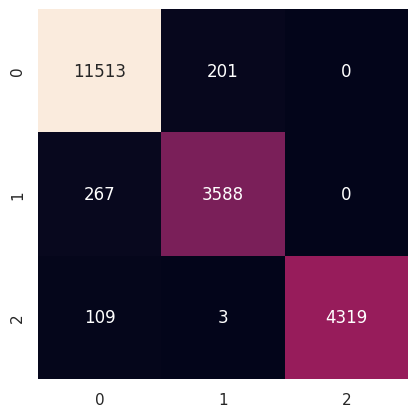

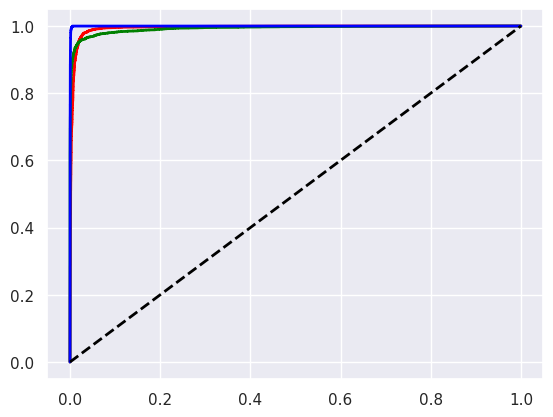

In [4]:
clf.evaluate(X_test, y_test)

Save the model to be used for comparison

In [ ]:
path = '../../models/RF/'
name = f'RandomForest__{o[withOutliers]}_outliers{d[data]}'
clf.save(new_name=name, path=path)